<H3>Rick and Morty subtitle analysis </H3>

I am a fan of Rick and Morty series. That's a fantastic, humorous and dramatic story about grandpa Rick and it's grandson Motry's interdimensional journeys.

The original goal was to analyse all of the existing episodes, however it turned out to be difficult to find all the subtitles and texts, so I limited my research to 4 seasons.

<b>Objective:<b/>
    
- split subtitles to words and calculate frequency of each word
- make a chart of word frequency
- have fun doing the project
    
<h4>This study consists of several parts:</h4>
    
1) reading srt files and work with it (split into words, remove stop words)\
2) heatmap of the 20 most frequent words\
3) parsing subtitles from a fan-website\
4) wordcloud for series and its main characters\
5) counting curse words

### Import

In [153]:
import pandas as pd
import seaborn as sns
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import string

In [154]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [3]:
pd.set_option('display.max_colwidth', None)  # Max symbol in a string displayed
pd.set_option('display.max_rows', None)

Let's start with usual subtitles, I have files for the first four seasons. 
- I'll read them, 
- clean from unnecessary symbols like "?, !" etc, 
- set to lower case so that not to count "you" and "You" as different words, 
- split word by word and calculate how many times each word have been used in each episode. 

### Reading srt files

Firstly I take a look at what I have

In [5]:
first_episode = open('Subs_1/1-1.srt', 'r', encoding='utf-8').read().splitlines()
first_episode[:11]

['\ufeff1',
 '00:00:02,378 --> 00:00:03,211',
 '[ FOOTSTEPS APPROACHING ]',
 '',
 '2',
 '00:00:03,295 --> 00:00:04,587',
 'Morty, you got to come on.',
 '',
 '3',
 '00:00:04,672 --> 00:00:06,130',
 'You got to come with me.']

Here is a function that takes a folder name as an argumen, read all the files there and returns df with words and its frequency

In [6]:
def srt_to_df(folder):    
    #read all the files names in a folder
    file_list = os.listdir(folder)    

    subtitles = pd.DataFrame({'word': [], 'frequency': [],'episode': []})

    for ep_no, file_name in enumerate(file_list):
        #read file
        file_contents = open(folder+file_name, 'r', encoding='utf-8').read().splitlines()

        #delete unnecessary symbols and numbers
        text_cleaned = [re.sub(r"[^a-zA-Z' ]", '', text) for text in file_contents]

        #better to work with string than list
        text_cleaned = ' '.join(text_cleaned)

        #set all words to lower case
        text_cleaned = text_cleaned.lower()

        #split text to list of words    
        words = text_cleaned.split()

        #count words 
        word_count = Counter(words)

        #put it to list from dict with items method
        word_frequency_list = list(word_count.items())

        #make DF and set columns
        word_frequency = pd.DataFrame(word_frequency_list, columns=['word', 'frequency'])
        word_frequency['episode'] = ep_no + 1
        subtitles = pd.concat([subtitles, word_frequency], ignore_index=True)
    return subtitles

In [7]:
#this loop collects data from several folders 
folders = ['Subs_1/', 'Subs_2/', 'Subs_3/', 'Subs_4/']
first_forth_ep_srt = pd.DataFrame({'word': [], 'frequency': [],'episode': [], 'season': []})

for season_no, folder_name in enumerate(folders):
    season = srt_to_df(folder_name)
    season['season'] = season_no+1
    first_forth_ep_srt = pd.concat([first_forth_ep_srt, season], ignore_index=True)

#### Words per episode

Let's see how many words per episode we have. Visualise it with a bar plot 

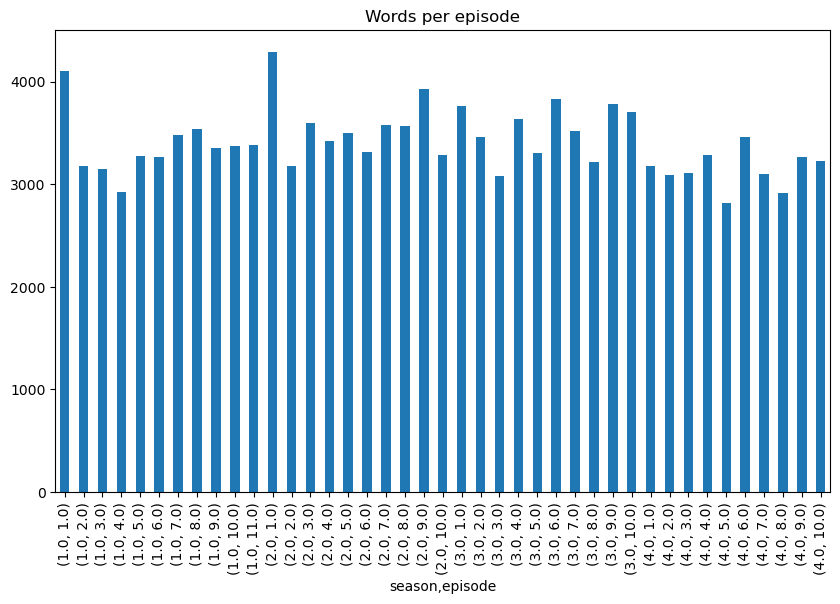

3400  words per episode in average


In [239]:
avg_words = first_forth_ep_srt.groupby(['season', 'episode'])['frequency'].sum()

plt.figure(figsize=(10, 6))
first_forth_ep_srt.groupby(['season', 'episode'])['frequency'].sum().plot(kind='bar')
plt.title('Words per episode')
plt.show()
print(round(avg_words.mean()), ' words per episode in average',)

Number of words is approximately the same in all episodes with a slight difference. 3400 words in average. Which are the most popular?

In [8]:
first_forth_ep_srt.groupby('word')['frequency'].sum().sort_values(ascending=False).head(10)

word
you     4850.0
the     3671.0
i       3640.0
to      3102.0
a       3090.0
and     1983.0
it      1892.0
of      1879.0
that    1683.0
is      1485.0
Name: frequency, dtype: float64

expectedly the most popular words are articles and pronouns. Let's delete this words that are called stop.

#### Stop words 

In [9]:
stop_words = set(stopwords.words('english'))

Here is a list of words w/o stop wors

In [10]:
w_o_stop_words_1_4 = first_forth_ep_srt[~first_forth_ep_srt['word'].isin(stop_words)]

See the most popular words from season to season

In [33]:
top_words = pd.DataFrame({'word': []})
# here is a pivot table with the most popular words for each season, I merged all 4 to one file
for n_season in list(range(1,5)):
    
    top = w_o_stop_words_1_4.query('season == {}'.format(n_season))\
                      .pivot_table(index="word", columns='season', values='frequency', aggfunc='sum')\
                      .reset_index()             
                      
    top.columns = ['word', 'season_{}'.format(n_season)]
    top = top.sort_values(by='season_{}'.format(n_season), ascending=False).head(20)    
    
    top_words = top_words.merge(top, on='word', how='outer')     


Let's see the result on a heatmap

### Frequency heatmap

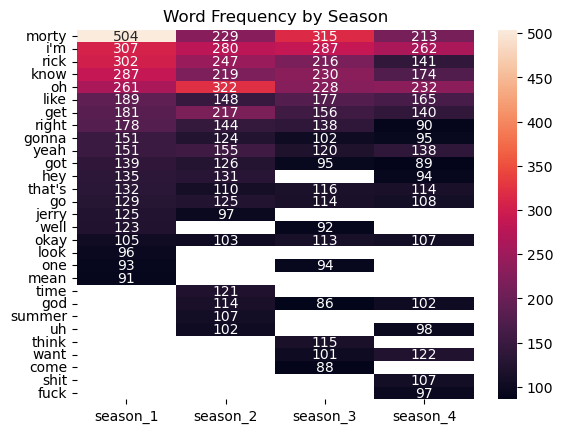

In [48]:
data = top_words.iloc[:, 1:]  # Exclude first column with words
columns = top_words.columns[1:]  # headings w/o first

# heatmap
sns.heatmap(data, annot=True, fmt=".0f", xticklabels=columns, yticklabels=top_words["word"])
plt.title("Word Frequency by Season")
plt.show()

Looks like both Rick and Morty were called less from season to season. In fourth season the last two words are curse ones 

I wanted to make a word cloud portrait of main characters, but I need a script with names for that. I found a fan website with full script for several seasons https://rickandmorty.fandom.com/ and tried to parse dialogs for my purpose

### Try parsing

Honestly these scripts are too detailed with description of what person was doing while speaking. Firstly I wrote a function that gets all the info from class "poem" and then split each line info before ":" and after.  

#### First markup

In [52]:
def text_by_roles(soup):
    
    # Get text from <div class="poem">    
    poem_text = soup.find('div', class_='poem').get_text()

    # Remove text in []
    poem_text = re.sub(r'\[.*?\]', '', poem_text)

    # Split text into lines
    lines = poem_text.split('\n')
    
    # variables 
    names = []  
    dialogs = []  
    current_speaker = None

    for line in lines:
        if ':' in line:
            # Split line into speaker and its dialog one time 
            name, dialogue = line.split(':', 1)
            name = name.strip()
            dialogue = dialogue.strip()

            # append to our lists
            names.append(name) 
            dialogs.append(dialogue)  

        else:
            # If there is no ':' add text to the previous dialog
            if current_speaker:
                dialogs[-1] = dialogs[-1] + line.strip()

    df = pd.DataFrame({"speaker": names, "dialogue": dialogs})
  
    return df


It appeared that not all the episodes are marked with such tags (div = poem), so it only worked for 2 episodes

In [53]:
episodes_name = ['Pilot', 'Lawnmower_Dog']

episodes_1_2 = pd.DataFrame({'speaker': [], 'dialogue': [],'episode': []})

for episode, name in enumerate(episodes_name):
    # URL 
    url = "https://rickandmorty.fandom.com/wiki/"+name+"/Transcript"
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    #apply our functin
    season = text_by_roles(soup)
    
    #add num of episode
    season['episode'] = episode + 1
    
    episodes_1_2 = pd.concat([episodes_1_2, season], ignore_index=True)
    

In [55]:
episodes_1_2.head()

speaker  \
0    Rick   
1   Morty   
2    Rick   
3   Morty   
4    Rick   

                                                                                                                                                          dialogue  \
0                                                  (stumbles in drunkenly, and turns on the lights) Morty! You gotta come on. You got--... you gotta come with me.   
1                                                                                                                     (rubs his eyes) What, Rick? What’s going on?   
2                                                                                                                                 I got a surprise for you, Morty.   
3                                                                                                        It's the middle of the night. What are you talking about?   
4  (spills alcohol on Morty's bed) Come on, I got a surprise for you. (drags Morty by the ankle) Come on, hurry up. (pulls Morty out of his bed and into the hall)   

   episode  
0      1.0  
1      1.0  
2      1.0  
3      1.0  
4      1.0

Since 3rd episode site markups are different, there is no "poem" div anymore, but paragraphs (&lt;p&gt;) and bold  (&lt;b&gt;) inside it to show the speaker. So I made another function

#### Second markup

In [56]:
def text_by_role_3rd_ep(soup):
    # page loading
    response = requests.get(soup)

    soup = BeautifulSoup(response.text, "html.parser")

    # find <p> elements
    dialogue_elements = soup.find_all("p")
    names = []  # list for names
    dialogs = []  # list for dialogues

    for p_element in dialogue_elements:
        
        b_tag = p_element.find("b")

        if b_tag:
            name = b_tag.get_text(strip=True)  # Get text from <b> (name)
            dialog = p_element.get_text(strip=True).replace(name, '', 1)  # the rest of the text is dialog

            names.append(name)  # add name of current <p> tag into a list
            dialogs.append(dialog)  # add dialog of current <p> tag into a list
        elif ":" in p_element.get_text():
            # Split string into "speaker" and "dialog" based on ":"
            name, dialog = p_element.get_text().split(":", 1)
            name = name.strip()
            dialog = dialog.strip()

            names.append(name)  # Добавляем имя текущего абзаца в список "имя"
            dialogs.append(dialog)  # Добавляем диалог текущего абзаца в список "диалог"
        else:
            # Если ни <b>, ни ":" не найдены, то текст добавляется к предыдущему "диалогу"

            # Проверяем, если предыдущий "диалог" пуст добавляем имя и текст из тега р
            if not dialogs:
                dialog = p_element.get_text(strip=True)
                name = 'action1'

                names.append(name)  # Добавляем имя текущего абзаца в список "имя"
                dialogs.append(dialog)  # Добавляем диалог текущего абзаца в список "диалог"
                #если список не пуст и в теге нет : и b то добавляем то что в теге к предыдущему элементу
            else:
                dialogs[-1] = dialogs[-1] + p_element.get_text(strip=True)
            
    df = pd.DataFrame({"speaker": names, "dialogue": dialogs})
    return df

In [57]:
episode = ['Anatomy_Park_(episode)', 'M._Night_Shaym-Aliens!', 'Meeseeks_and_Destroy', 'Rick_Potion_No._9',\
           'Raising_Gazorpazorp', 'Rixty_Minutes', 'Something_Ricked_This_Way_Comes', \
           'Close_Rick-Counters_of_the_Rick_Kind', 'Ricksy_Business']

episodes_3_11 = pd.DataFrame({'speaker': [], 'dialogue': [],'episode': []})

for episode, name in enumerate(episode):
    # URL веб-сайта
    
    if episode+3 == 9:
        
        continue
    else:    
        url = "https://rickandmorty.fandom.com/wiki/"+name+"/Transcript"

        season = text_by_role_3rd_ep(url)

        season['episode'] = episode + 3

        episodes_3_11 = pd.concat([episodes_3_11, season], ignore_index=True)   

In [64]:
episodes_3_11['dialogue'] =  episodes_3_11['dialogue'].str.replace(r'\n', '')   
episodes_3_11['speaker'] = episodes_3_11['speaker'].str.replace(r':', '')
episodes_3_11.head()

C:\Users\1\AppData\Local\Temp\ipykernel_12320\1342313050.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  episodes_3_11['dialogue'] =  episodes_3_11['dialogue'].str.replace(r'\n', '')


speaker  \
0  action1   
1    Jerry   
2    Jerry   
3    Jerry   
4     Beth   

                                                                                                                                                                                                                                                                       dialogue  \
0                                                                                                                  [Open Ext. Smith residence](Outside, there is snow on the ground. TheSmith houseisdecorated for Christmas, andJerrycan be heard singingLast King Christmas.)   
1                                                                                                *singing* Last King Christmas last arrived![Trans Int. Kitchen](The kitchen is a mess of food in various stages ofpreparation. Jerry pulls a ham out of the oven as he sings.)   
2  *singing*In the Christmas Christmas! *stops singing and smells the ham* Mmm... Jerry, youare really giving it to this ham.(Jerry enters the living room, where a tree stands withpresents underneath it.BethandMortyare occupied on tablets whileSummeruses her smartphone.)   
3                                                                                                                     Um,Merry Christmas? *puts his hands on his hips* Helloooo? My parents are comingover for the first time in years! Can we stow the gadgets and look alive?   
4                                                                                                                                                                                                Alive?Foryourparents?(Jerry snags her tablet away and stows it in a stocking.)   

   episode  
0      3.0  
1      3.0  
2      3.0  
3      3.0  
4      3.0

I also found a problem with episode 9 - it has only couple of &lt;p> tag, so I worked with it the other way. 
Firstly I put all the dialogs into a string

#### Thidr markup 9 episode

In [65]:
url = "https://rickandmorty.fandom.com/wiki/Something_Ricked_This_Way_Comes/Transcript"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

dialogue_elements = soup.find_all("p")

# epmty string for text
full_text = ""

# Iterate over the <p> elements and adjust their text to the full text
for element in dialogue_elements:
    full_text += element.get_text()

In [66]:
full_text[100:800]

'on 1. It aired on\xa0March 24, 2014.\n[Open: Smith kitchen, int. Rick, Jerry, Beth are eating breakfast. Rick is building a robot at the table. Jerry is playing Jerry’s Game](Rick starts welding. The bulk of the sparks fly towards Jerry, who turns away to dodge the bulk of them. Morty enters the room)Morty: Hey Rick, I have to make a project for the science fair this weekend. You think you could help me out?Rick: Whatever.Jerry: Well, um, traditionally science fairs are a father-son thing.Rick: Well, scientifically, traditions are an idiot thing.Beth: [typing on phone] Morty, I think it will be fun for you to work on a science project with your dad.(Beth sends Morty a text saying “Your father is'

Then I had to clean the text from \n as they were rather hectic and aslo remove description of scene in [  ]

In [67]:
cleaned_string = re.sub(r'\[.*?\]|\n', '', full_text)

The other problem was with spaces, they were not after each punctuation mark and to be able to split text in speaker and its dialog I added spaces after each punctuation mark if there wasn't any

In [68]:
#Iterate over each word and add space in there is punctuation mark
cleaned_text = ""
for char in cleaned_string:
    cleaned_text += char
    if char in string.punctuation:
        cleaned_text += " "

And finally split text into speaker and its words. 

In [69]:

dialogues = []
speakers = []

# variables to make a string of text befor add it to the main dialog
current_speaker = None
current_dialogue = ""

# split text into words
words = cleaned_text.split()  

for word in words:
    # If a word ends with":" and starts with a capital letter put it to speaker
    if word.endswith(":") and word[:-1].istitle():
        #if current speaker not empty
        if current_speaker:
            speakers.append(current_speaker)
            dialogues.append(current_dialogue)
        
        current_speaker = word
        current_dialogue = ""
    else:
        # else add it to current dialog
        if current_dialogue:
            current_dialogue += " "
        current_dialogue += word

# For the last dialogue
if current_speaker:
    speakers.append(current_speaker)
    dialogues.append(current_dialogue)

episode_9 = pd.DataFrame({"speaker": speakers, "dialogue": dialogues})



In [71]:
episode_9['episode'] = 9
episode_9['speaker'] = episode_9['speaker'].str.replace(r':', '')
episode_9.head()

speaker  \
0   Morty   
1    Rick   
2   Jerry   
3    Rick   
4    Beth   

                                                                                                                                                                                 dialogue  \
0                                                                                  Hey Rick, I have to make a project for the science fair this weekend. You think you could help me out?   
1                                                                                                                                                                               Whatever.   
2                                                                                                                          Well, um, traditionally science fairs are a father- son thing.   
3                                                                                                                                    Well, scientifically, traditions are an idiot thing.   
4  Morty, I think it will be fun for you to work on a science project with your dad. ( Beth sends Morty a text saying “Your father is insecure about his intelligence” which Morty reads)   

   episode  
0        9  
1        9  
2        9  
3        9  
4        9

Let's unite whole season!

In [73]:
first_season = pd.concat([episodes_1_2, episodes_3_11, episode_9], ignore_index=True)
first_season['episode'] = first_season['episode'].astype(int)

In [74]:
first_season.head()

speaker  \
0    Rick   
1   Morty   
2    Rick   
3   Morty   
4    Rick   

                                                                                                                                                          dialogue  \
0                                                  (stumbles in drunkenly, and turns on the lights) Morty! You gotta come on. You got--... you gotta come with me.   
1                                                                                                                     (rubs his eyes) What, Rick? What’s going on?   
2                                                                                                                                 I got a surprise for you, Morty.   
3                                                                                                        It's the middle of the night. What are you talking about?   
4  (spills alcohol on Morty's bed) Come on, I got a surprise for you. (drags Morty by the ankle) Come on, hurry up. (pulls Morty out of his bed and into the hall)   

   episode  
0        1  
1        1  
2        1  
3        1  
4        1

Then I need to count all the word, but words in brackets 

In [76]:
# function to split text into words and count them 
def count_words(text):
    text = re.sub(r'\([^)]*\)', '', text)
    # Split text into words
    words = text.split()
    return len(words)


In [77]:
first_season['word count'] = first_season['dialogue'].apply(count_words)


In [78]:
first_season.groupby('episode')['word count'].sum()

episode
1     3998
2     3067
3     3094
4     2963
5     3161
6     3281
7     3357
8     3974
9     3047
10    3673
11    3448
Name: word count, dtype: int64

Looks like the amount of words more or less the same, nothing unusual

#### Second season

In [79]:
episodes_2 = ['A_Rickle_in_Time', 'Mortynight_Run', 'Auto_Erotic_Assimilation', 'Total_Rickall', 'Get_Schwifty_(episode)',\
           'The_Ricks_Must_Be_Crazy', 'Big_Trouble_in_Little_Sanchez', 'Interdimensional_Cable_2:_Tempting_Fate', \
           'Look_Who%27s_Purging_Now', 'The_Wedding_Squanchers']

In [80]:
second_season = pd.DataFrame({'speaker': [], 'dialogue': [],'episode': []})

for episode, name in enumerate(episodes_2):
    # URL веб-сайта
    url = "https://rickandmorty.fandom.com/wiki/"+name+"/Transcript"
    season = text_by_role_3rd_ep(url)
    season['episode'] = episode + 1

    second_season = pd.concat([second_season, season], ignore_index=True)   

In [81]:
second_season['word count'] = second_season['dialogue'].apply(count_words)


In [82]:
second_season['episode'] = second_season['episode'].astype(int)
second_season['speaker'] = second_season['speaker'].str.replace(':', '')

In [83]:
second_season.groupby('episode')['word count'].sum()

episode
1     4327
2     3385
3     3761
4     3601
5     3435
6     3593
7     3294
8     2518
9     4330
10    1071
Name: word count, dtype: int64

In [84]:
second_season.head()

speaker  \
0  transcript   
1      (Enter   
2      Summer   
3       Morty   
4      Summer   

                                                                                                                                                                                                                                                              dialogue  \
0  This article is aof theRick and MortyepisodeA Rickle in TimefromSeason 2. It aired on July 26, 2015.[Open aerial view/zoom on the Smith home](Morty,Rick, andJerry)(Everything is frozen besides Morty, Rick and Summer. Morty is vacuuming Jerry with a hand vac.)   
1                                                                                                                                                                                                                                                              Summer)   
2                                                                                                                                                          Hurry up Morty, Grampa's about to unfreeze time. You know you really should be cleaning from top to bottom.   
3                                                                                                                                                                                         I know how to vacuum Mom and Dad, Summer, I've been doing it for six months!   
4                                                                                                                                                                                            Then you've been doing itwrongfor six months. Oh, my God, is that mildew?   

   episode  word count  
0        1          23  
1        1           1  
2        1          19  
3        1          16  
4        1          13

#### Third season

Third is a bit messy as it contains differect tags, but I've delt with them before, so just need to combine

In [85]:
season_3_poem = ['The_Rickshank_Rickdemption', 'Rickmancing_the_Stone', 'Pickle_Rick', \
              'Vindicators_3:_The_Return_of_Worldender']
season_3_p = ['The_Whirly_Dirly_Conspiracy', 'Rest_and_Ricklaxation', 'The_Ricklantis_Mixup', 'The_Rickchurian_Mortydate']

season_3_dl = ['Morty%27s_Mind_Blowers', 'The_ABC%27s_of_Beth']


In [86]:
def dl_tag(url):
    response = requests.get(url)

    soup = BeautifulSoup(response.text, "html.parser")

    dialogue_elements = soup.find_all("dl")

    # epmty string for text
    full_text = ""

    # Iterate over the <p> elements and adjust their text to the full text
    for element in dialogue_elements:
        full_text += element.get_text()

    cleaned_string = re.sub(r'\[.*?\]|\n', '', full_text)

    #Iterate over each word and add space in there is punctuation mark
    final = ""
    for char in cleaned_string:
        final += char
        if char in string.punctuation:
            final += " "

    dialogues = []
    speakers = []

    # variables to make a string of text befor add it to the main dialog
    current_speaker = None
    current_dialogue = ""

    # split text into words
    words = final.split()  

    for word in words:
        # If a word ends with":" and starts with a capital letter put it to speaker
        if word.endswith(":") and word[:-1].istitle():
            #if current speaker not empty
            if current_speaker:
                speakers.append(current_speaker)
                dialogues.append(current_dialogue)

            current_speaker = word
            current_dialogue = ""
        else:
            # else add it to current dialog
            if current_dialogue:
                current_dialogue += " "
            current_dialogue += word

    # For the last dialogue
    if current_speaker:
        speakers.append(current_speaker)
        dialogues.append(current_dialogue)

    episode = pd.DataFrame({"speaker": speakers, "dialogue": dialogues})
    return episode


In [87]:
thidr_season = pd.DataFrame({'speaker': [], 'dialogue': [],'episode': []})

for episode, name in enumerate(season_3_poem):
    # URL веб-сайта
    url = "https://rickandmorty.fandom.com/wiki/"+name+"/Transcript"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    season = text_by_roles(soup)
    season['episode'] = episode + 1

    thidr_season = pd.concat([thidr_season, season], ignore_index=True)   

In [92]:
thidr_season_2 = pd.DataFrame({'speaker': [], 'dialogue': [],'episode': []})

for episode, name in enumerate(season_3_p):
    url = "https://rickandmorty.fandom.com/wiki/"+name+"/Transcript"

    season = text_by_role_3rd_ep(url)

    season['episode'] = episode + 5

    thidr_season_2 = pd.concat([thidr_season_2, season], ignore_index=True)   

In [89]:
thidr_season_3 = pd.DataFrame({'speaker': [], 'dialogue': [],'episode': []})

for episode, name in enumerate(season_3_dl):
    url = "https://rickandmorty.fandom.com/wiki/"+name+"/Transcript"

    season = dl_tag(url)

    season['episode'] = episode + 9

    thidr_season_3 = pd.concat([thidr_season_3, season], ignore_index=True)   

In [93]:
thidr_season_final = pd.concat([thidr_season, thidr_season_2, thidr_season_3,], ignore_index=True)   

In [94]:
thidr_season_final['word count'] = thidr_season_final['dialogue'].apply(count_words)

In [95]:
thidr_season_final.groupby('episode')['word count'].sum()

episode
1.0     3804
2.0     3096
3.0     2513
4.0     3502
5.0     3100
6.0     4104
7.0     4162
8.0     3230
9.0      639
10.0     634
Name: word count, dtype: int64

I have lack of words for last 2 episodes, so I checked the website and it's just not whole episode, nothing that I can do 

In [164]:
first_season['season'] = 1
second_season['season'] = 2
thidr_season_final['season'] = 3
three_seasons_together = pd.concat([first_season, second_season, thidr_season_final,], ignore_index=True)  
three_seasons_together['speaker'] = three_seasons_together['speaker'].str.replace(':', '')
three_seasons_together['dialogue'] = three_seasons_together['dialogue'].str.lower()

In [165]:
three_seasons_together.head()

speaker  \
0    Rick   
1   Morty   
2    Rick   
3   Morty   
4    Rick   

                                                                                                                                                          dialogue  \
0                                                  (stumbles in drunkenly, and turns on the lights) morty! you gotta come on. you got--... you gotta come with me.   
1                                                                                                                     (rubs his eyes) what, rick? what’s going on?   
2                                                                                                                                 i got a surprise for you, morty.   
3                                                                                                        it's the middle of the night. what are you talking about?   
4  (spills alcohol on morty's bed) come on, i got a surprise for you. (drags morty by the ankle) come on, hurry up. (pulls morty out of his bed and into the hall)   

   episode  word count  season  curse_words_1  curse_words_2  burps  
0      1.0          12       1            0.0            0.0    NaN  
1      1.0           5       1            0.0            0.0    NaN  
2      1.0           7       1            0.0            0.0    NaN  
3      1.0          11       1            0.0            0.0    NaN  
4      1.0          12       1            0.0            0.0    NaN

### Wordcloud

Let's see how would portrait of 3 seasons look

In [166]:
three_seasons_together_srt = thidr_season_final['dialogue'].to_string(index=False)
three_seasons_together_srt = three_seasons_together_srt.lower()

In [155]:
def cloud(string):    
    wordcloud = WordCloud(width=1600, height=800).generate(string)
    plt.figure( figsize=(20,10), facecolor='k')
    # добавляем туда облако слов
    plt.imshow(wordcloud)
    # выключаем оси и подписи
    plt.axis("off")
    # убираем рамку вокруг
    plt.tight_layout(pad=0)
    # выводим картинку на экран
    return plt.show()

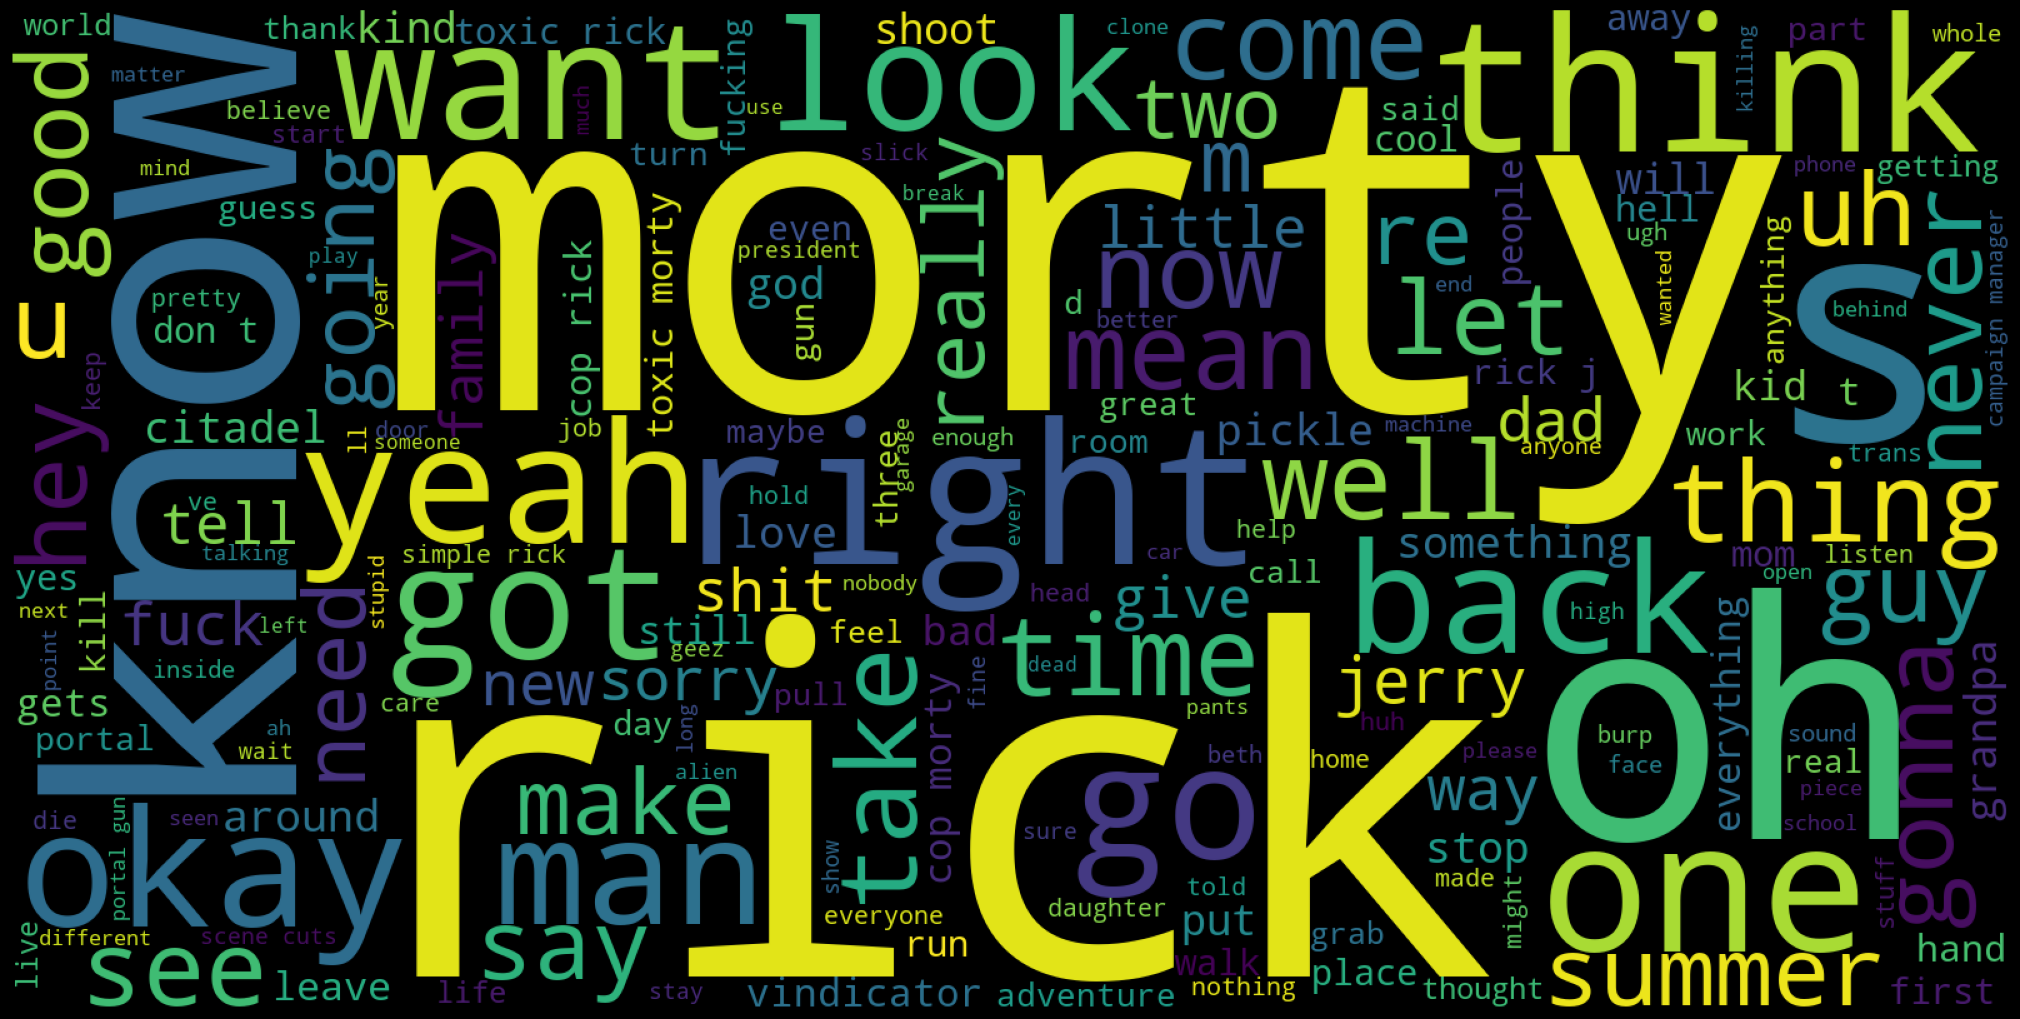

In [167]:
cloud(three_seasons_together_srt)

Main characters are visible

Let's split the words into adj, noun and verbs and make portraits of the main characters based on verbs and adj

In [169]:
# Function to split string to noun, adj and verb
def part_of_speech(text_list):
    text_str = text_list.to_string(index=False)
    word = word_tokenize(text_str)

    # Determine the part of speech for each word
    pos_tags = pos_tag(word)

    adjectives = []
    verbs = []
    nouns = []

    for word, pos in pos_tags:
        if pos.startswith('JJ'):  # adj
            adjectives.append(word)
        elif pos.startswith('VB'):  # verb
            verbs.append(word)
        elif pos.startswith('NN'):  # nounn 
            nouns.append(word)
            
    #adjectives = adjectives.to_string(index=False)        
    return adjectives, verbs, nouns

Before making a portrait I deleted all the words in brackets about charaters action

In [181]:
three_seasons_no_brackets = three_seasons_together[['speaker', 'dialogue', 'season', 'episode']]
three_seasons_no_brackets['dialogue'] = three_seasons_no_brackets['dialogue'].str.replace(r'\(.*\)', '', regex=True)
 #text_cleaned = [re.sub(r"(^a-zA-Z' )", '', text) for text in file_contents]

C:\Users\1\AppData\Local\Temp\ipykernel_12320\2073230568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_seasons_no_brackets['dialogue'] = three_seasons_no_brackets['dialogue'].str.replace(r'\(.*\)', '', regex=True)


In [183]:
three_seasons_no_brackets.head()

speaker                                                         dialogue  \
0    Rick   morty! you gotta come on. you got--... you gotta come with me.   
1   Morty                                     what, rick? what’s going on?   
2    Rick                                 i got a surprise for you, morty.   
3   Morty        it's the middle of the night. what are you talking about?   
4    Rick                                                                    

   season  episode  
0       1      1.0  
1       1      1.0  
2       1      1.0  
3       1      1.0  
4       1      1.0

#### How would portrait of Rick look like

In [185]:
rick_adj, rick_v, rick_n = part_of_speech(three_seasons_no_brackets.query('speaker == "Rick"')['dialogue'])

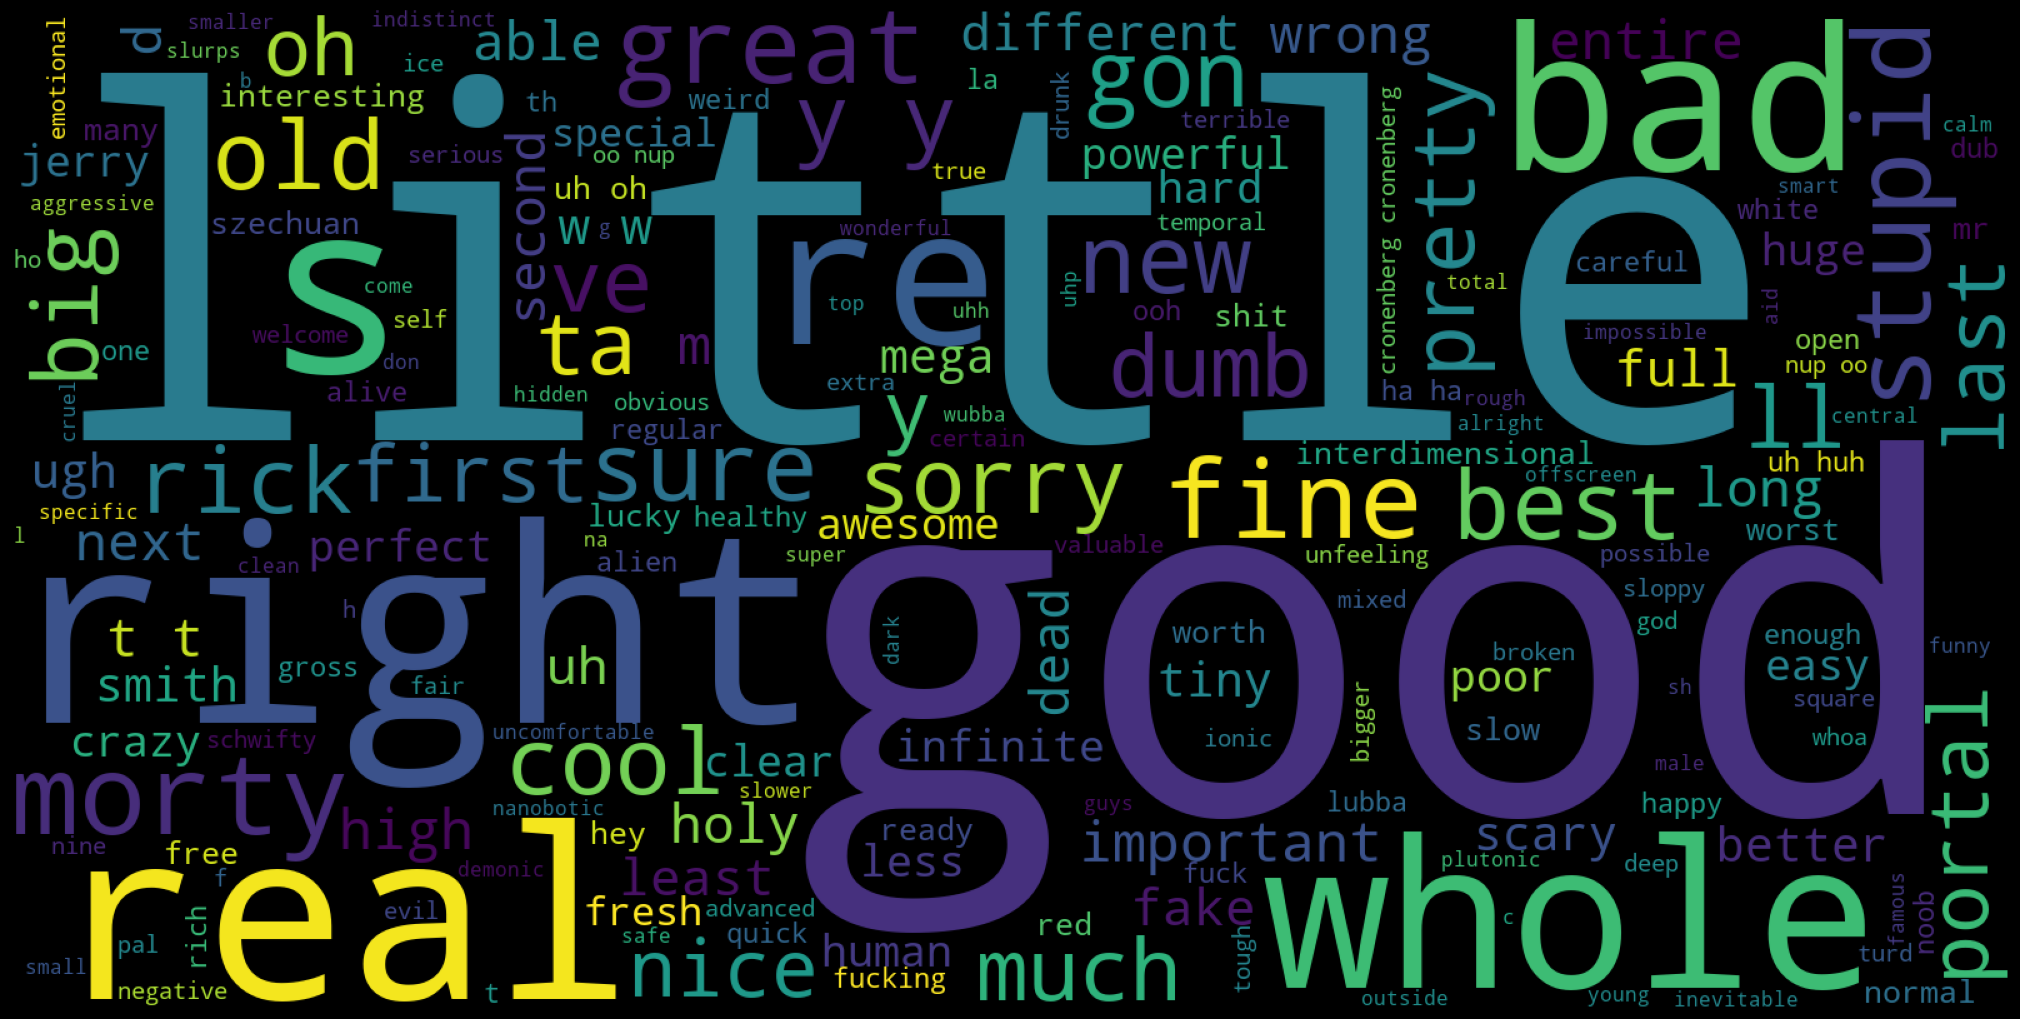

In [186]:
cloud(','.join(rick_adj))

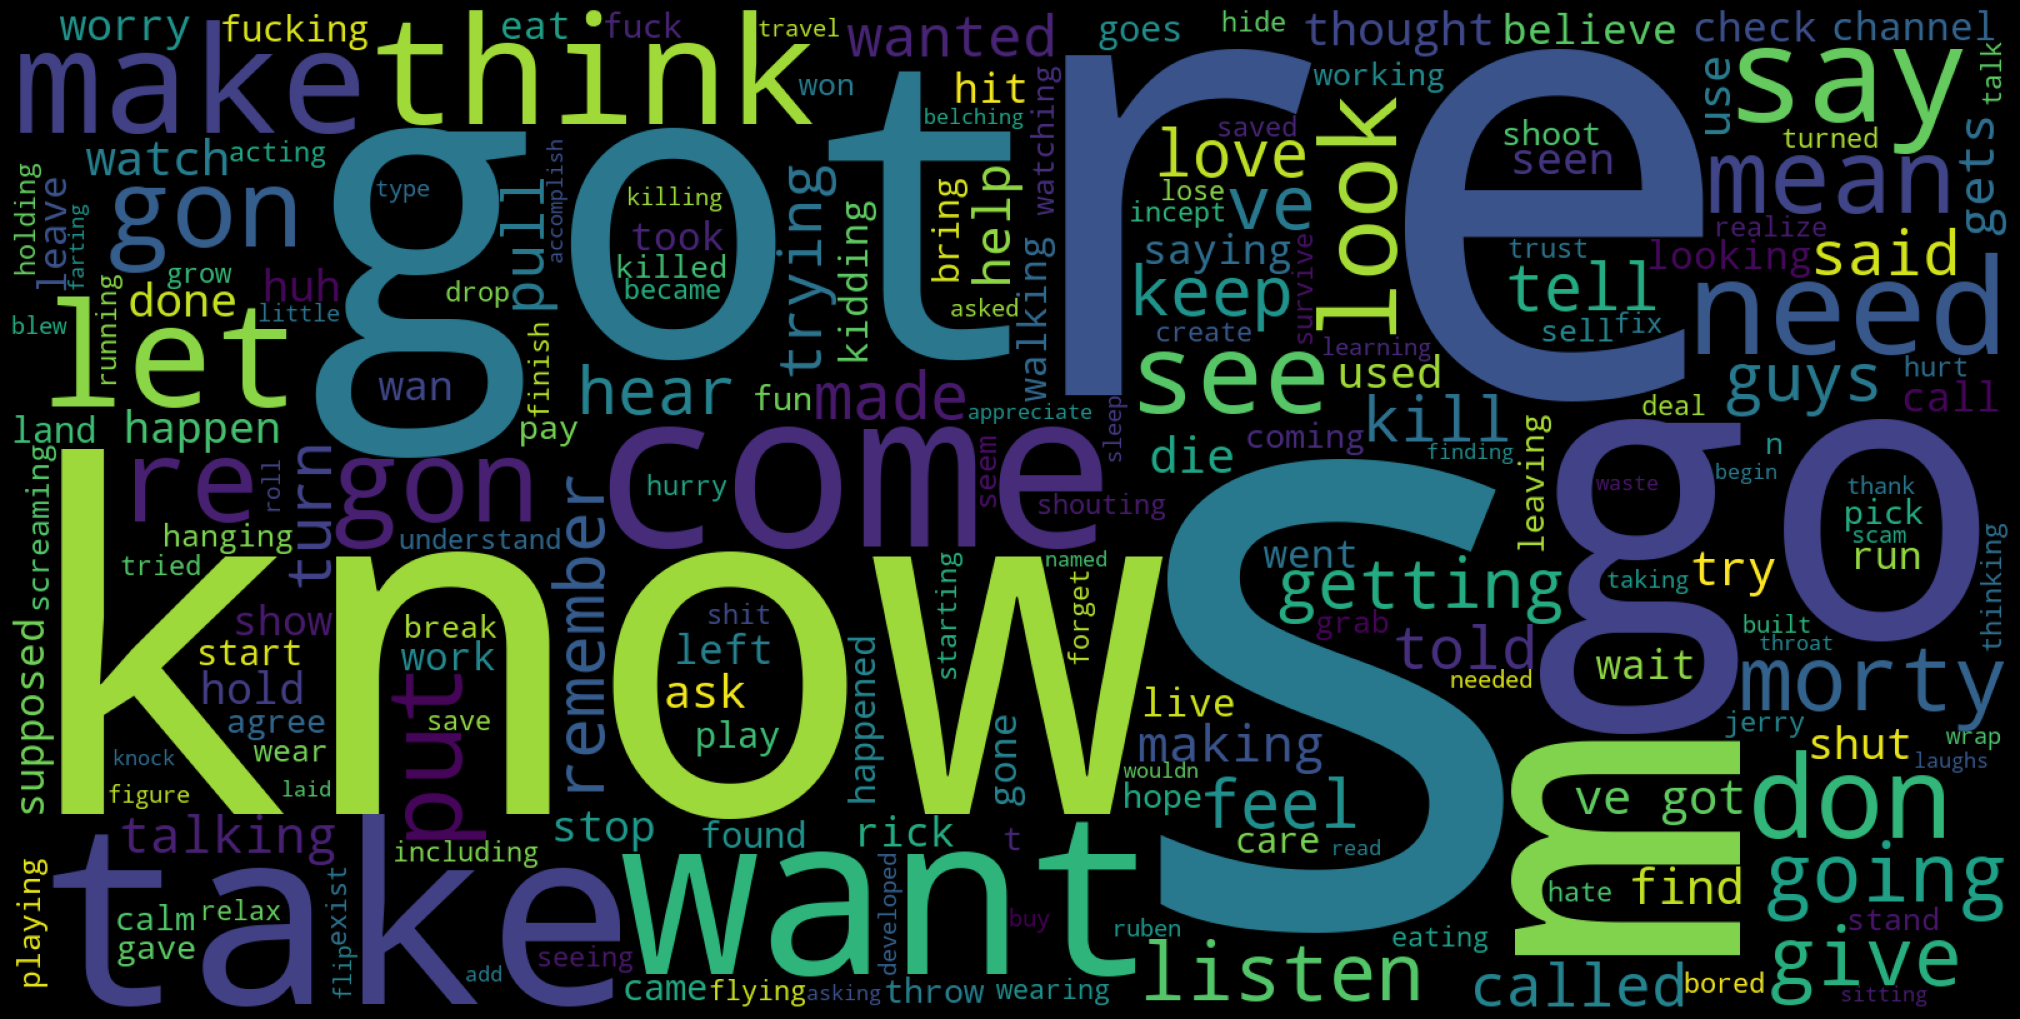

In [187]:
cloud(','.join(rick_v))

#### Portrait of Motry

In [189]:
morty_adj, morty_v, morty_n = part_of_speech(three_seasons_no_brackets.query('speaker == "Morty"')['dialogue'])

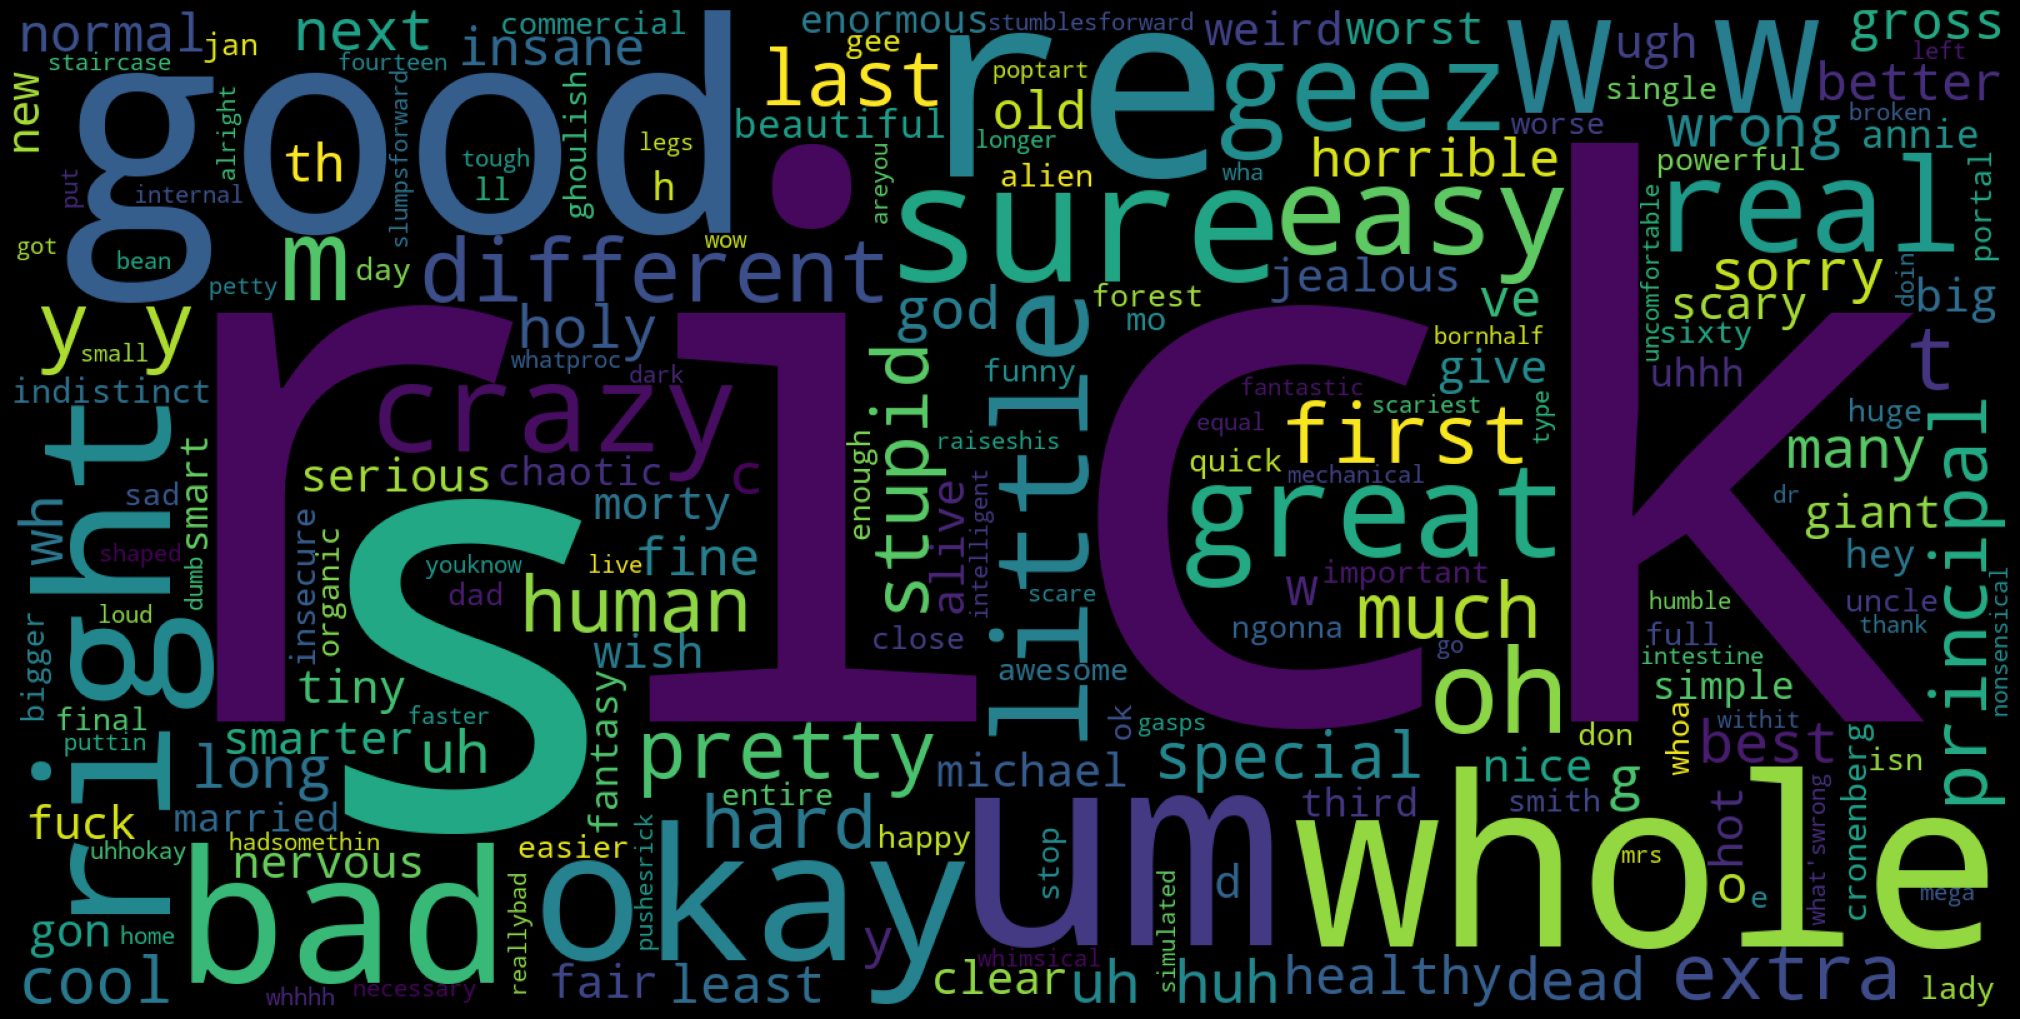

In [190]:
cloud(','.join(morty_adj))

Morty calls Rick way more then Rick calls Morty. okay is also appears more often

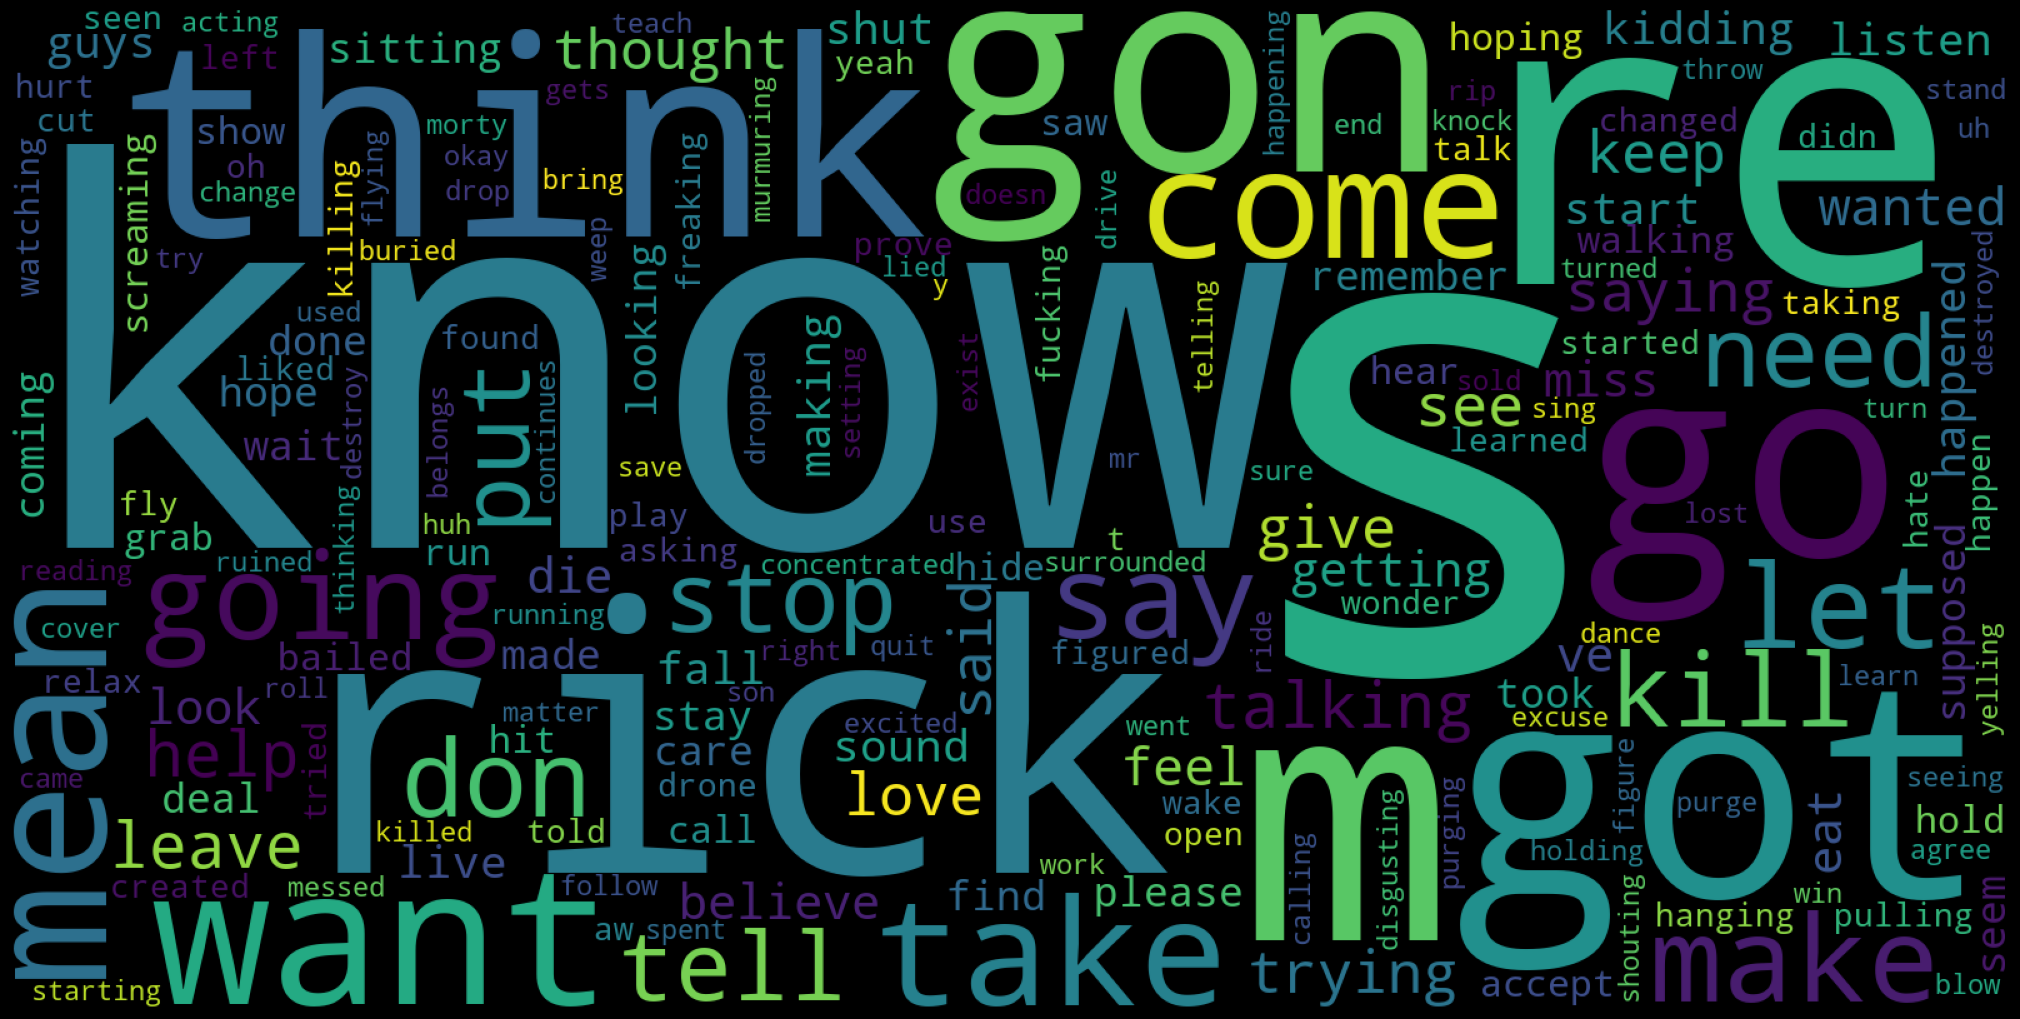

In [191]:
cloud(','.join(morty_v))

#### Portrait of Jerry

In [192]:
Jerry_adj, Jerry_v, Jerry_n = part_of_speech(three_seasons_no_brackets.query('speaker == "Jerry"')['dialogue'])

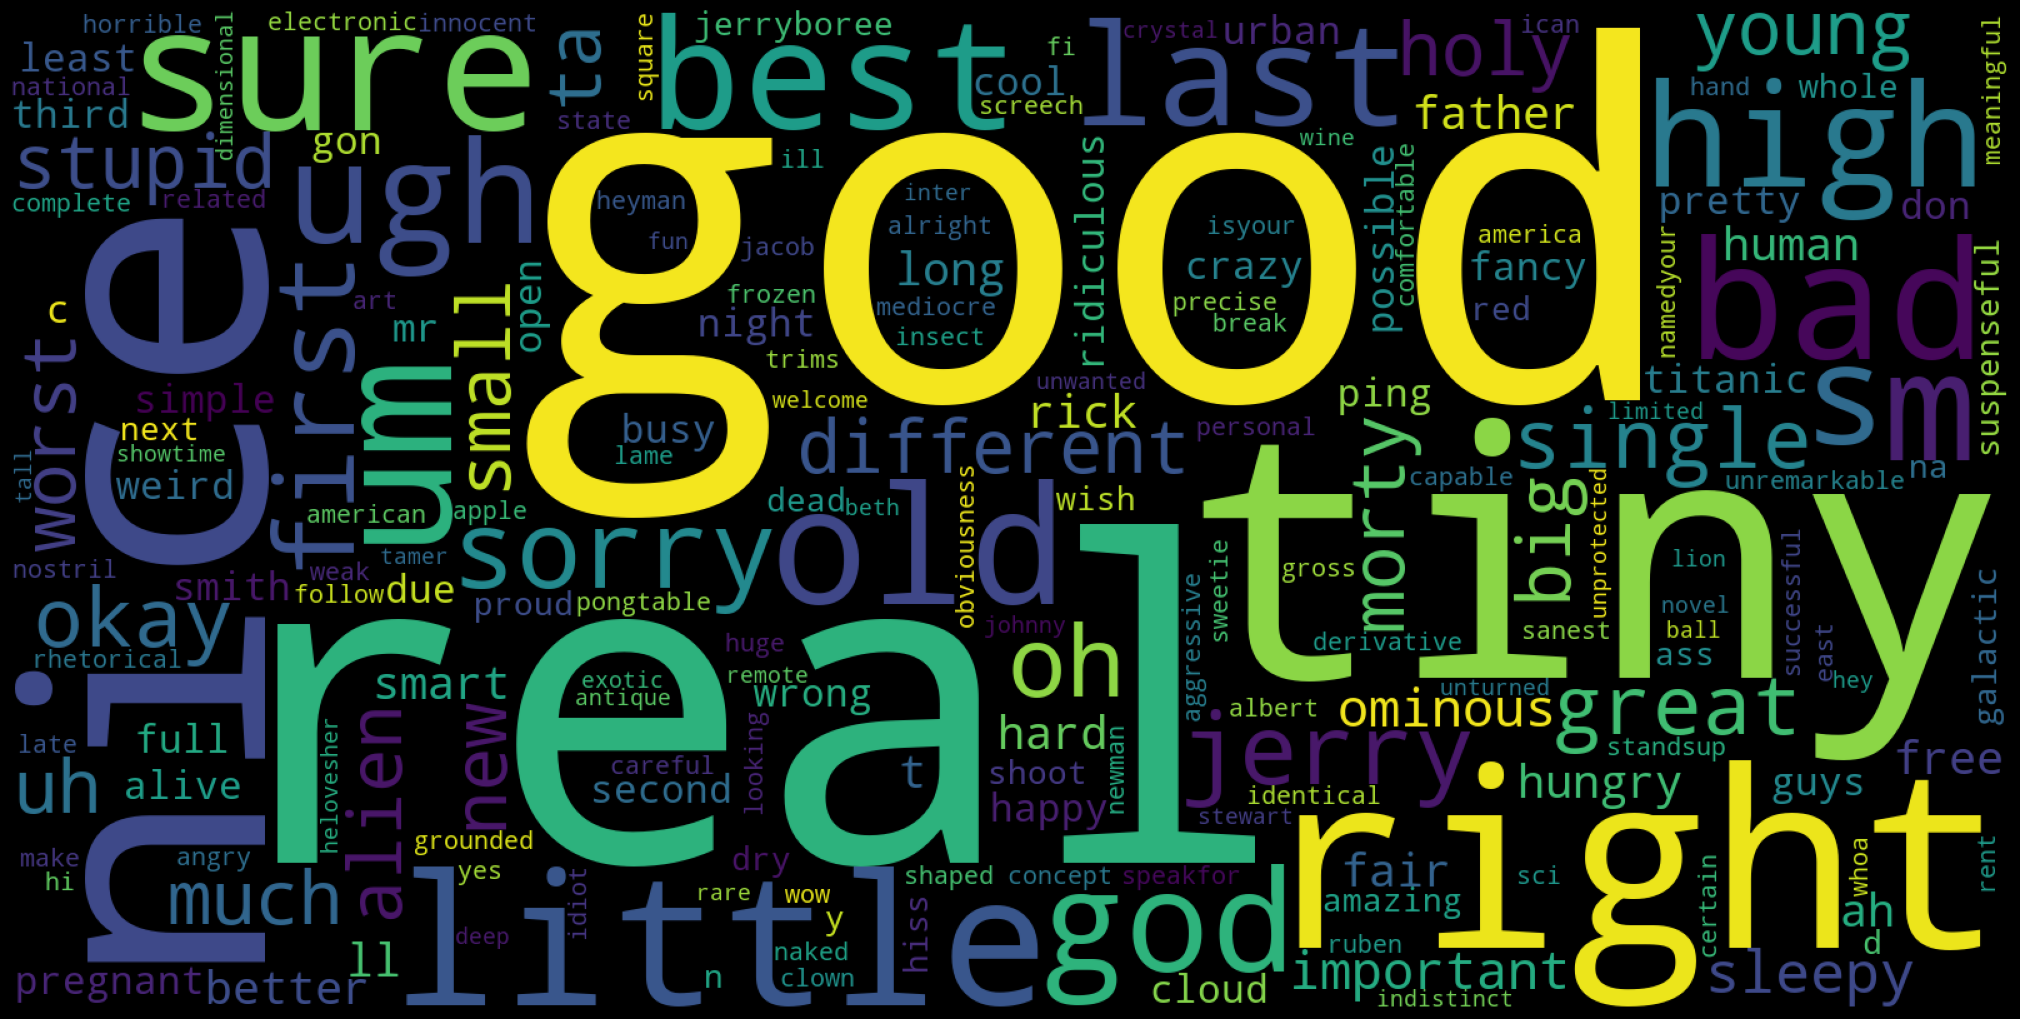

In [193]:
cloud(','.join(Jerry_adj))

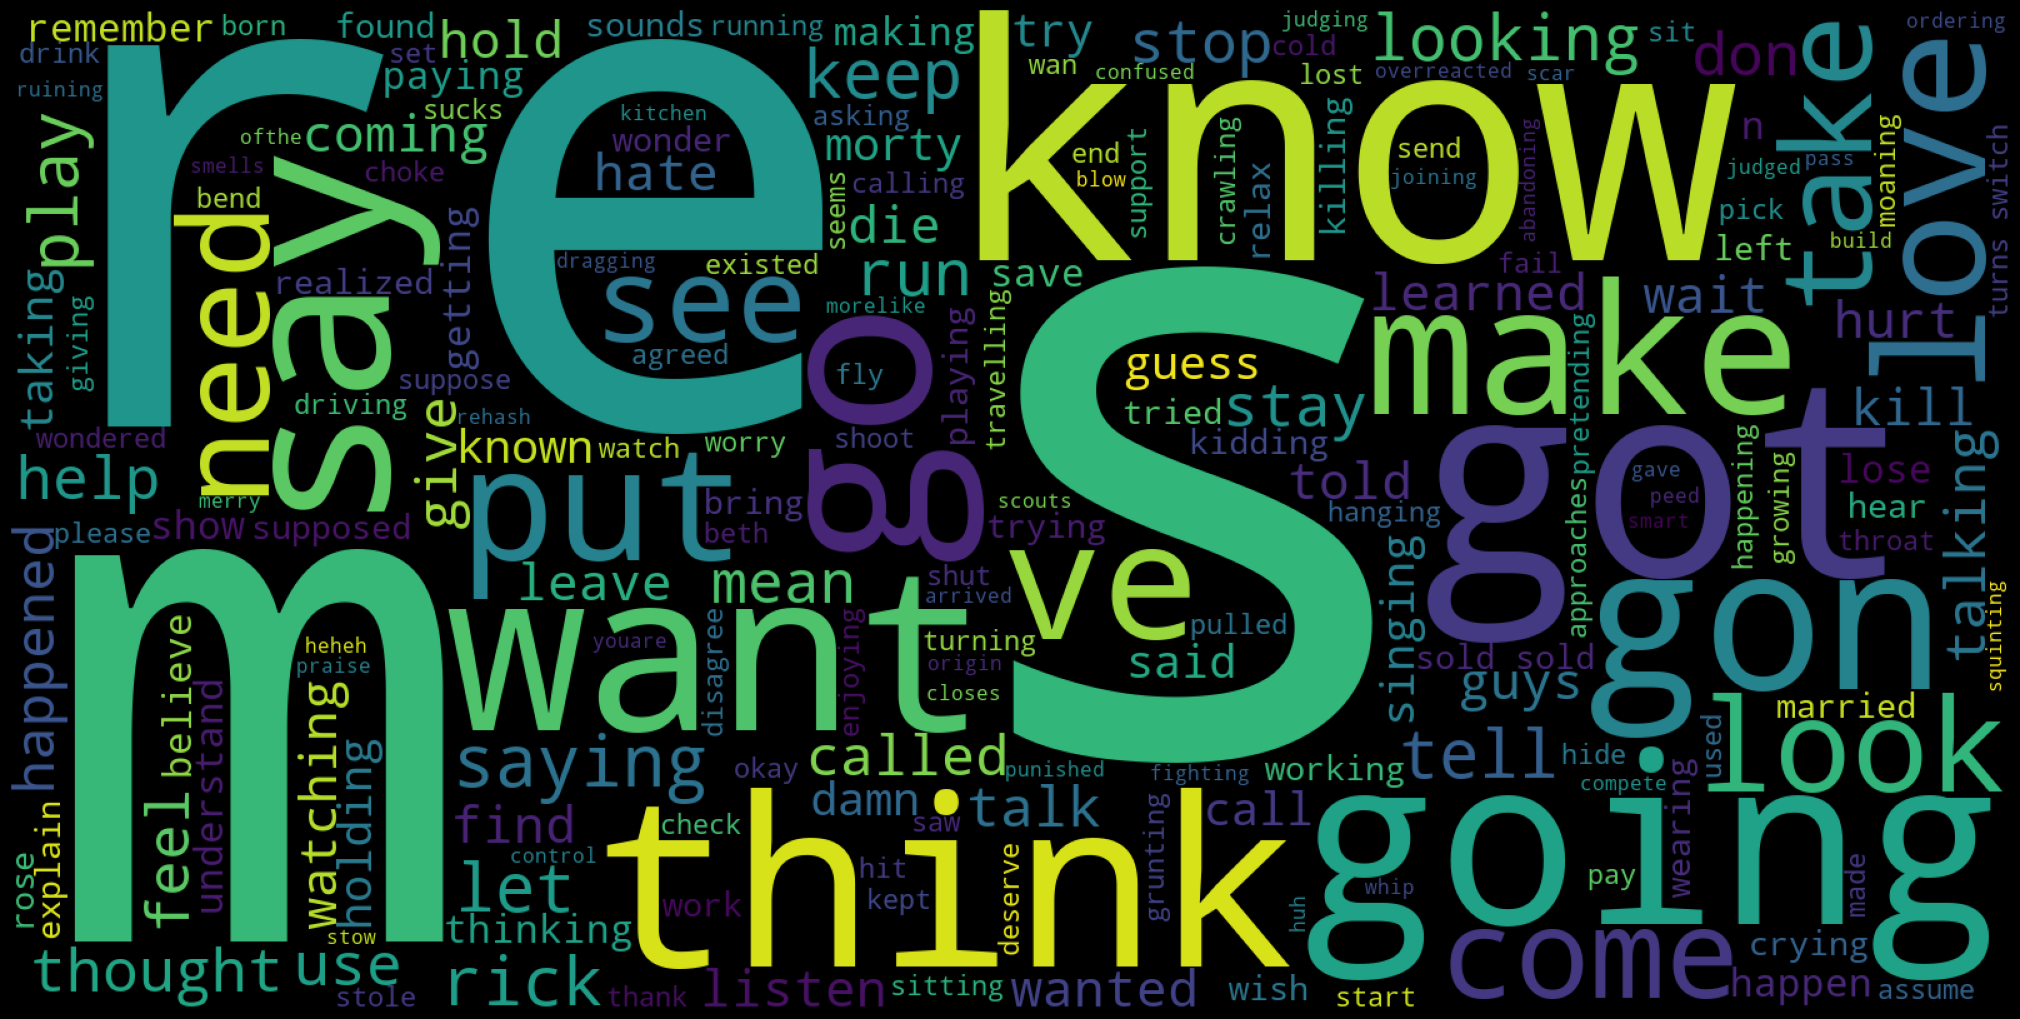

In [194]:
cloud(','.join(Jerry_v))

### Curse count

Next chapter is about curse words, I divide curse words in two groups curse_words_1 - strong ones, curse_words_2 - lighter. Then I made a functioon that count bad words in each line of a dataframe.

In [201]:
curse_words_1 = ['fuck', 'bitch', 'pussy', 'cunt', 'faggot']
curse_words_2 = ['whore', 'slut', 'shit', 'bastard', 'dick', 'asshole', 'crap', 'dumb', 'jerk']
three_seasons_together['dialogue'] = three_seasons_together['dialogue'].astype(str)

In [204]:
# Function for counting number of words out of a list
def count_c_words(text, list_w):
    text = text.lower()  # set to lowercase
    count = sum(text.count(word) for word in list_w)
    return count

# New column with count
three_seasons_together['curse_words_1'] = three_seasons_together['dialogue'].apply(count_c_words, args=(curse_words_1,))
three_seasons_together['curse_words_2'] = three_seasons_together['dialogue'].apply(count_c_words, args=(curse_words_2,))

In [205]:
main_char_1 = three_seasons_together.query('speaker == ["Rick", "Morty"]')

In [240]:
main_char_1['season_ep'] = main_char_1['season'] + (main_char_1['episode']/100)  
main_char_1.head()

C:\Users\1\AppData\Local\Temp\ipykernel_12320\3524879937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_char_1['season_ep'] = main_char_1['season'] + (main_char_1['episode']/100)


speaker  \
0    Rick   
1   Morty   
2    Rick   
3   Morty   
4    Rick   

                                                                                                                                                          dialogue  \
0                                                  (stumbles in drunkenly, and turns on the lights) morty! you gotta come on. you got--... you gotta come with me.   
1                                                                                                                     (rubs his eyes) what, rick? what’s going on?   
2                                                                                                                                 i got a surprise for you, morty.   
3                                                                                                        it's the middle of the night. what are you talking about?   
4  (spills alcohol on morty's bed) come on, i got a surprise for you. (drags morty by the ankle) come on, hurry up. (pulls morty out of his bed and into the hall)   

   episode  word count  season  curse_words_1  curse_words_2  burps  season_ep  
0      1.0          12       1              0              0    NaN       1.01  
1      1.0           5       1              0              0    NaN       1.01  
2      1.0           7       1              0              0    NaN       1.01  
3      1.0          11       1              0              0    NaN       1.01  
4      1.0          12       1              0              0    NaN       1.01

Barplot 

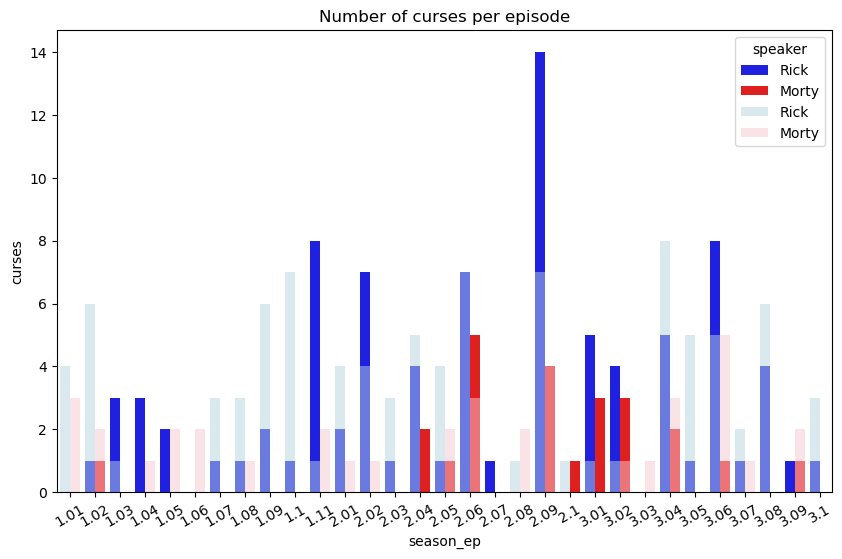

In [219]:
plt.figure(figsize=(10, 6))
#strong curses
ax = sns.barplot(x='season_ep', 
                 y='curse_words_1', 
                 hue='speaker', 
                 data=main_char_1, 
                 ci=None, 
                 palette=['blue', 'red'],
                 estimator=sum)

# light curses
ax = sns.barplot(x='season_ep', 
                 y='curse_words_2', 
                 hue='speaker', 
                 data=main_char_1, 
                 ci=None, 
                 palette=['lightblue', 'pink'],
                 alpha=0.5,
                 estimator=sum)


# Set up column labels
plt.xticks(rotation=30)
plt.ylabel('curses')
plt.title('Number of curses per episode')

plt.show()

Here is a barplot, for strong  cuses I set brighter color, and for light ones lighter color. Looks like Morty grew up a bit and started to curse almost as much as Rick does.

### F word

Calculate how many f words were said per episode, including fucking, fucker etc.

In [242]:
three_seasons_together['fuck'] = three_seasons_together['dialogue'].apply(lambda text: str(text).count('fuck'))

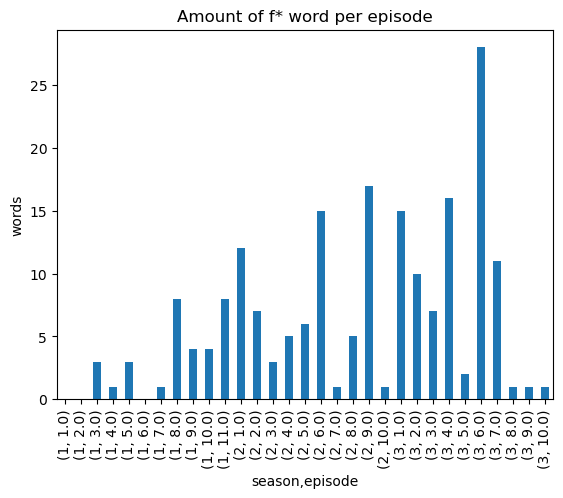

In average amount of f* word per episode: 6


In [238]:
curse = three_seasons_together.groupby(['season', 'episode'])['fuck'].sum()
curse.plot(kind='bar')
plt.title('Amount of f* word per episode')
plt.ylabel('words')
plt.show()
print('In average amount of f* word per episode:', round(curse.mean()))

Looks like the amount of f words grew from season to season, and probles with data at the and of the graph